# COMP3314 Assignment4-Q3: K-means Clustering (40 Points)


In this task, we'll utilize the k-means algorithm to compress image colors. Consider an image containing millions of colors. Typically, many of these colors remain unused, with numerous pixels sharing similar or identical colors.


Your tasks:

1. Utilize Scikit-Learn's implementation to perform color compression.
2. Independently implement the k-means algorithm.
3. Investigate the impact of initial point selection on the results.

## Step 1: Image processing (code given)
Display the example image and transform it into a set of data points.

In [1]:
"""
You'll need to install necessary packages, e.g.
- numpy
- matplotlib
- pillow
- scikit-learn
- and etc.
"""

import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

Image's shape     : (360, 480, 3)
Image's data type : float32
Image's data range: [0. 0. 0.] ~ [1. 1. 1.]


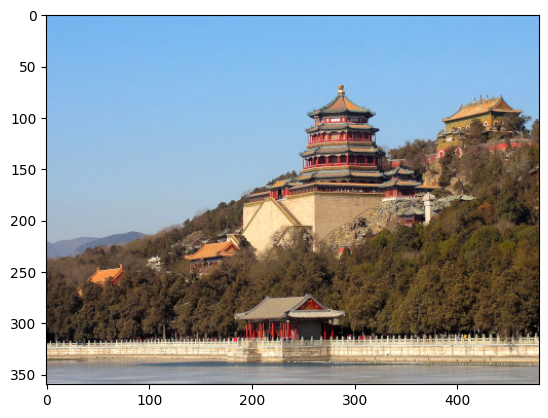

In [2]:
def load_image_from_url(url):
    """
    Load an image from a URL and return it as a floating-point numpy array.

    Args:
        url (str): The URL of the image.

    Returns:
        np.ndarray: Floating-point array representation of the image, or None if an error occurred.
    """
    try:
        response = requests.get(url)
        if response.status_code == 200:
            im = Image.open(BytesIO(response.content))
            if im.mode != "RGB":
                im = im.convert("RGB")
            im_array = np.asarray(im).astype("float32") / 255.0
            return im_array
        else:
            print(
                f"Failed to retrieve the image: Status code {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


im = load_image_from_url(
    "https://github.com/comp3314/hw-data/releases/download/hw3/summer_palace.jpg"
)
print(f"Image's shape     : {im.shape}")
print(f"Image's data type : {im.dtype}")
print(
    f"Image's data range: {np.min(im, axis=(0,1))} ~ {np.max(im, axis=(0,1))}")

plt.imshow(im)
plt.show()

Reshape the image as a collection of points within a three-dimensional color space. We'll reshape it into `(n_samples, n_features)`, where `n_samples` is the number of pixels in the image and `n_features` is 3, representing the RGB values of each pixel.

In [3]:
data = im.reshape(-1, 3)
print(data.shape)

(172800, 3)


## Step 2: Implement K-means with random initialization (10 points)

You're given the following framework code for the K-means algorithm. You'll need to implement:

- `_initialize_centers_random()`: Initialize the cluster centers randomly (5 points).
- `fit()`: Fit the data to the model (5 points).

In [71]:
import numpy as np
from numpy import ndarray
import random

def distance(point1, point2)->float:
    return np.sqrt(np.sum((point1-point2)**2))

class KMeans:
    def __init__(self, n_clusters=8, max_iter=300, initialization="random"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.cluster_centers_: ndarray | None = None
        self.initialization = initialization

        if self.initialization not in ["random", "fps"]:
            raise ValueError("Invalid initialization method.")

    def _initialize_centers_random(self, X: ndarray):
        """
        Initialize the cluster centers by randomly selecting `n_clusters` samples.
        """
        # === Your code here ===
        self.cluster_centers_ = ndarray((self.n_clusters, 3), dtype=float)
        for i in range(self.n_clusters):
            for j in range(3):
                self.cluster_centers_[i][j] = random.random()
        # ======================

    def _initialize_centers_fps(self, X: ndarray):
        """
        Initialize the cluster centers by using the Farthest Point Sampling
        (FPS) algorithm.

        - It starts from a randomly selected sample as the first center.
        - Then in each iteration, it selects the sample that is the farthest
          from the set of selected centers.
        """
        # === Your code here ===
        self.cluster_centers_ = ndarray((self.n_clusters, 3), dtype=float)
        self.cluster_centers_[0] = random.choice(X)
        for i in range(1, self.n_clusters):
            center_of_selected_centers = np.mean(self.cluster_centers_, axis=0)
            selected_center_index = np.argmax([distance(data_point, center_of_selected_centers) for data_point in X])
            self.cluster_centers_[i] = X[selected_center_index]
        # ======================

    def fit(self, X: ndarray):
        if self.initialization == "random":
            self._initialize_centers_random(X)
        elif self.initialization == "fps":
            self._initialize_centers_fps(X)
        else:
            raise ValueError("Invalid initialization method.")

        # === Your code here ===
        
        for i in range(self.max_iter):
            center_to_data_points = {i: [] for i in range(self.n_clusters)}
            for data_point in X:
                closest_center = np.argmin([distance(data_point, center_point) for center_point in self.cluster_centers_])
                center_to_data_points[closest_center].append(data_point)
            for center in center_to_data_points.keys():
                if len(center_to_data_points[center])==0:
                    continue
                self.cluster_centers_[center] = np.mean(center_to_data_points[center], axis=0)
            print(i)
        # ======================

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distances, axis=1)

Now, let's run your code and visualize the compression results.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'Compressed Image (Random Init)')

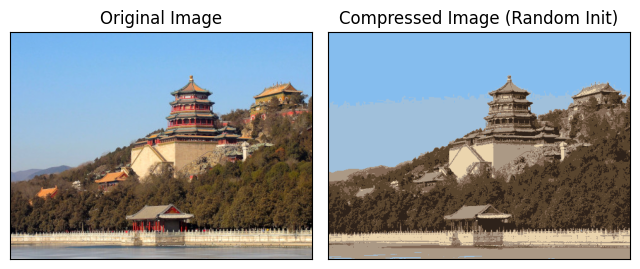

In [70]:
"""
Do not change code in this cell.
"""

kmeans = KMeans(n_clusters=10, max_iter=300, initialization="random")
kmeans.fit(data)
im_compressed = kmeans.cluster_centers_[kmeans.predict(data)].reshape(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(
    8, 4), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(im)
ax[0].set_title("Original Image")
ax[1].imshow(im_compressed)
ax[1].set_title("Compressed Image (Random Init)")

## Step 3: Initialization by furthest point sampling (10 points)

Next, implement the `_initialize_centers_fps()` method to initialize the cluster centers by the FPS algorithm. It starts from a randomly selected sample as the first center. Then in each iteration, it selects the sample that is the farthest from the set of selected centers. We'll the visualize the results.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'Compressed Image (FPS Init)')

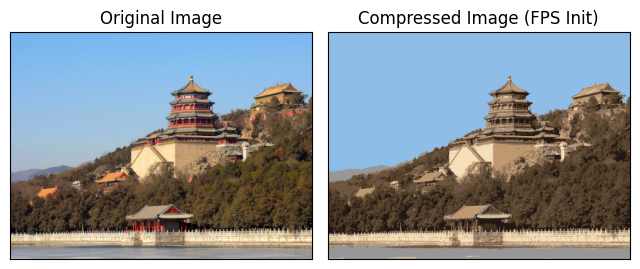

In [76]:
"""
Do not change code in this cell.
"""

kmeans = KMeans(n_clusters=10, max_iter=300, initialization="fps")
kmeans.fit(data)
im_compressed = kmeans.cluster_centers_[kmeans.predict(data)].reshape(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(
    8, 4), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(im)
ax[0].set_title("Original Image")
ax[1].imshow(im_compressed)
ax[1].set_title("Compressed Image (FPS Init)")

## Step 4: Evaluate the compression qualitatively (10 points)

Plot and compare the results of the random and FPS initialization methods, by setting the number of clusters to 4, 8, and 16 for both methods.

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


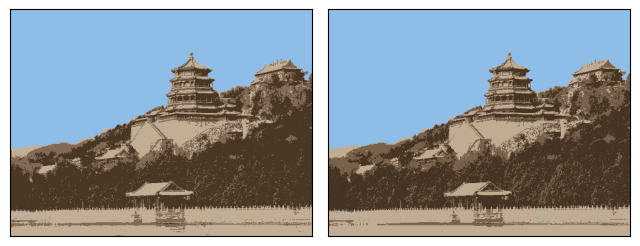

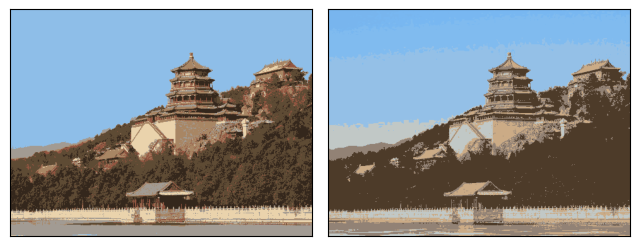

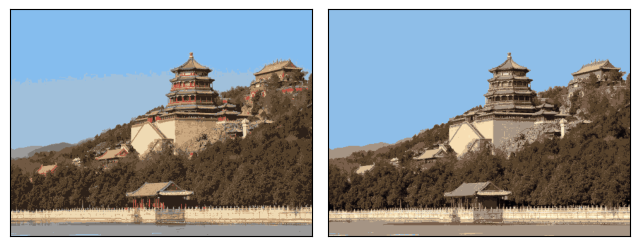

In [78]:
# === Your code here ===
kmeans = [
KMeans(n_clusters=4, max_iter=10, initialization="random"),
KMeans(n_clusters=8, max_iter=10, initialization="random"),
KMeans(n_clusters=16, max_iter=10, initialization="random"),
KMeans(n_clusters=4, max_iter=10, initialization="fps"),
KMeans(n_clusters=8, max_iter=10, initialization="fps"),
KMeans(n_clusters=16, max_iter=10, initialization="fps")
]

for kmean in kmeans:
    kmean.fit(data)

compressed_images = [kmean.cluster_centers_[kmean.predict(data)].reshape(im.shape) for kmean in kmeans]
for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(
        8, 4), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(wspace=0.05)
    ax[0].imshow(compressed_images[i])
    ax[1].imshow(compressed_images[i+3])
    # ======================

## Step 5: Evaluate the compression quantitatively (10 points)

One way of evaluating compression quality is by computing the mean squared error (MSE) between the original image and the compressed image. The MSE is defined as the average of the squared differences between the original and compressed images.

You're required to:

1. Impelment a `mean_squared_error()` method to calculate the mean squared error.
2. Compare the MSE for the random and FPS initialization methods, by setting the number of clusters to 4, 8, and 16 for both methods.

In [79]:
# === Your code here ===
def mean_squared_error(original, compressed):
    return np.mean(np.square(original-compressed))

for i, kmean in enumerate(kmeans):
    print(f"MSE for {kmean.n_clusters} clusters, {kmean.initialization} init: {mean_squared_error(im, compressed_images[i])}")
# ======================

MSE for 4 clusters, random init: 0.006073109505365437
MSE for 8 clusters, random init: 0.003173772869741457
MSE for 16 clusters, random init: 0.0017704400919154241
MSE for 4 clusters, fps init: 0.006023335138770691
MSE for 8 clusters, fps init: 0.0052518367826229866
MSE for 16 clusters, fps init: 0.0027232507026087567
